#HW 1
##Harry Potter and the Action Prediction Challenge from Natural Language
***
*Task based on https://github.com/PragmaticsLab/NLP-course-AMI/blob/dev/HW/hw1.ipynb*

*deadline: 7 марта 2021, 23:30*

В этом домашнем задании мы будем работать с корпусом Harry Potter and the Action Prediction Challenge. Корпус собран из фанфиков о Гарри Поттере и состоит из двух частей: 1) сырые тексты, 2) фрагменты текстов, описывающих ситуацию, в которой произнесено заклинание.

Корпус описан в статье: https://arxiv.org/pdf/1905.11037.pdf

David Vilares and Carlos Gómez-Rodríguez. Harry Potter and the Action Prediction Challenge from Natural Language. 2019 Annual Conference of the North American Chapter of the Association for Computational Linguistics. To appear.

Код для сбора корпуса находится в репозитории: https://github.com/aghie/hpac . Корпус можно скачать по инструкции из этого репозитория, но для экономии времени авторы задания уже скачали и подготовили данные к работе.

Ссылки на собранный корпус:

Сырые тексты: https://www.dropbox.com/s/23xet9kvbqna1qs/hpac_raw.zip?dl=0
Токенизированные тексты в нижнем регистре: https://www.dropbox.com/s/gwfgmomdbetvdye/hpac_lower_tokenized.zip?dl=0
train-test-dev: https://www.dropbox.com/s/3vdz0mouvex8abd/hpac_splits.zip?dl=0  
Части 1, 2 задания должны быть выполнены на полных текстах (сырых или предобработанных -- на ваше усмотрение), Часть 3 – на разбиение на тестовое, отладочное и обучающее множества. Тестовое множество должно быть использовано исключительно для тестирования моделей, обучающее и отладочное – для выбора модели и параметров.

##Installs and imports
***
Для начала установим недостающие и импортируем библиотеки которые нам потребуются.  

Первую часть задания реализуем с помощью *Word2Vec*.  
Вторую часть задания я решил сделать с помощью *FastText*.

Для работы с текстами на понадобятся библиотеки *Pandas*, *NLTK*, регулярные выражения и метрики для просмотра качества модели библиотеки *Sklearn*, а так же *t-SNE* и *matplotlib* для визуализации полученных результатов.


## Installs and imports

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3137190 sha256=7fb2836afc1c14654343424fa201e2526d9d8a255cdfe450f41a7f972b9bdeec
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import os
import re

from collections import defaultdict
from multiprocessing import Pool

import numpy as np
import fasttext
import pandas as pd
import nltk
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from gensim.models import word2vec
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet as wn
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##Text preprocessing and model corpus creation.
***
Тексты я разместил на диске.  
Для последующего чтения файлов и итерации по ним запомним путь к директории с файлами и создадим список имен всех файлов.  
Проверим все ли файлы вошли в список посмотрев его длину.

In [ ]:
directory = '/content/drive/MyDrive/harry_potter_data/fanfiction_texts/'
files = os.listdir(directory)
len(files)

36225

Создадим переменную для класса лемматизатора и для словаря стоп-слов.  
***
*Стоп-слова — это часто используемые слова, которые не вносят никакой дополнительной информации в текст. Слова типа "the", "is", "a" не несут никакой ценности и только добавляют шум в данные.*

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

Для предобработки текстов я написал функцию ***preprocess_file***.


*  Приводим все слова к нижнему регистру;
*  Разбиваем предложения на слова(*токены*);
*  Убираем все знаки кроме латинских букв;
*  Приводим все глаголы к инфинитиву(*я решил что для анализа частот слов и в целом для модели инфинитивы подойдут лучше*);
*  Убираем из текстов стоп-слова.
***
*\*** Далее я записываю обработанный текст построчно в отдельный файл.  
Так поступить пришлось из-за недостатка ОЗУ при работе с файлами напрямую, сеанс постоянно прерывался.  
TQDM используем для контроля процесса выполнения.*




In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def preprocess_file(file):
    result = []
    text = " ".join([line.lower().strip() for line in open(directory + file)])
    sentences = sent_tokenize(text)

    for sentence in sentences:
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [lemmatizer.lemmatize(word, 'v') for word in [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sentence.strip().split()] if word not in stop_words and len(word) > 1]
        #words = [lemmatizer.lemmatize(word, 'v') for word in sentence.strip().split() if word not in stop_words]
        result.append(words)
    
    return result




In [ ]:
f = open('/content/drive/MyDrive/corpus_complete_lemm.txt', "w")

for file in tqdm(files): 
    processed_file = preprocess_file(file)
    for sentence in processed_file:
        f.writelines(" ".join(sentence) + "\n")
f.close()

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/hpac_lemmes_full', sep='\t', header=None, names=["sentences"])
data = data.dropna()

In [ ]:
data.sentences.describe()


count     38842775
unique    29393457
top           know
freq         93721
Name: sentences, dtype: object

##Dataset analysis
***
Даллее идет блок работы с датасетом наших текстов.  

Объем данных оказался достаточно большим и многие операции над массивом данных вызывали переполнение ОЗУ при рпботе с Google Colab.  
В целях экономии места и сокращения однообразных шагов обработки я опишу свои действия в тексте и для части дейстий оставлю примеры вывода результата.  
Читаем на обопщенный файл:  
`data = pd.read_csv("/content/drive/MyDrive/corpus_complete_lemm.txt", sep='\n', names=['sentences'])`  
Проверяем наличие пропусков:  
`data['sentences'].isnull().sum()` У нас получается 6 пустых строк.  
Удаляем пустые строки:  
`data = data.dropna()`

Далее я решил добавить к датасету графы с количеством символов в предложениие и количеством слов.
Количество символов успешно выполнилось через метод:  
`df['sentences'].apply(len)`  
А вот подсчет слов через разбиение строки методами pandas:  
`clean_data['sentences'].str.split()`  
вызывало сброс сеанса, пришлось запусть подсчет слов в цикле и потом соединить датасеты в один.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/hpac_lemmes_full', sep='\t', header=None, names=["sentences"])

Посмотрим на описания граф нашего датасета.
Наш corpus насчитывает 38.8 млн предложений, 29.5 млн уникальных.  
Видимо, одним из популярных предложений в текстах является "I know." или подобные варианты.

In [ ]:
data.sentences.describe()

count     38869176
unique    29506529
top           know
freq         92906
Name: sentences, dtype: object

In [ ]:
data.head(10)

,sentences,len,words_count
0,bellatrix never good aim,24,4
1,taunt laugh least pain hit,26,5
2,could stare,11,2
3,pace back forth sirius go stir crazy,36,7
4,could owl harry,15,3
5,idea flash mind,15,3
6,mirror,6,1
7,secure might work harry mirror,30,5
8,hurriedly take mirror pocket,28,4
9,right little paranoid little suspicion never h...,56,8


Как видно из сводной таблицы, среднее количество слов в предложении - 6.  
Минимальная длина предложения - 1(не забываем, что мы удалили стоп-слова).    
Так же имеется выброс длиной в 1304 слова, возможно методика разбивки текста не подходт к данному тексту(ам).  
Так же можем увидеть процентили по датасету.

In [ ]:
data[{'len', 'words_count'}].describe().applymap(lambda x: f"{x:0.3f}")

,words_count,len
count,38869176.000,38869176.000
mean,6.171,37.779
std,4.835,31.564
min,1.000,1.000
25%,3.000,15.000
50%,5.000,30.000
75%,8.000,52.000
max,1304.000,19056.000


##Exploratory analysis
####Words Frequency distribution
***
Переходим к превой цели нашего исследования.  
1.   Найдем топ-1000 слов по частоте без учета стоп-слов.

Реализуем поиск слов и их частотностей с помощью ***nltk.FreqDist***.




In [ ]:
fd = FreqDist()

for sentence in tqdm(data['sentences']):
   words = sentence.split()
   fd.update(words)

top_1000_words = [(word[0], word[1]) for word in fd.most_common(1000)]

for word in top_1000_words:
    print(f"{word[0]:10s}  {word[1]:10d}")

  0%|          | 0/38842775 [00:00<?, ?it/s]

harry          4003055
say            2881365
know           1996383
look           1971896
go             1924978
hermione       1831544
would          1655272
think          1591592
get            1590901
one            1465761
back           1430188
draco          1390568
like           1367737
could          1303073
make           1200958
eye            1200152
take           1174291
time           1150773
want           1080002
well           1073840
ask            1064851
see            1050331
hand           1027447
come           1010563
ron             906591
tell            889168
head            862620
even            835507
around          767637
face            747237
turn            717228
try             705665
still           700102
leave           695304
give            694383
way             692663
smile           685227
room            683209
find            660041
severus         655677
ginny           639572
sirius          630274
potter          624446
something  

Для визуализации полученных результатов воспользуемся ***\"Облаком Слов"***.  
Так же создадим из этих слов логотип ***\"HP"*** используя маску изображения.

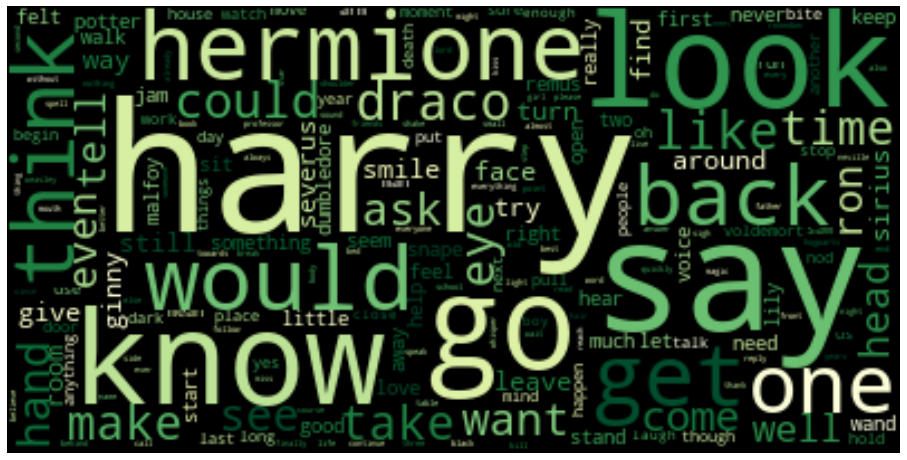

(-0.5, 727.5, 793.5, -0.5)

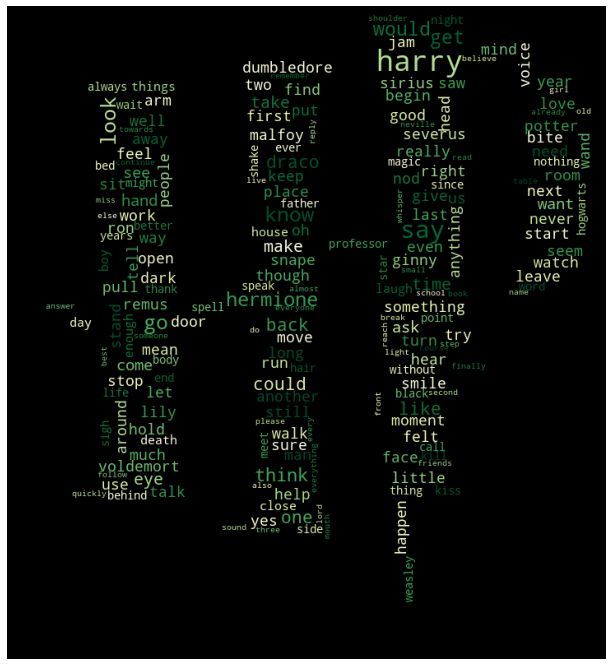

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=80,colormap="YlGn").generate_from_frequencies(fd)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

from PIL import Image
import numpy as np
hp_mask = np.array(Image.open("/content/drive/MyDrive/imgbin-harry-potter-and-the-prisoner-of-azkaban-sorting-hat-hogwarts-harry-potter-bMxhtPA6ggtNNRUPVYUXNeZpD.jpg"))

# Custom Colormap
from matplotlib.colors import LinearSegmentedColormap
#colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
#cmap = LinearSegmentedColormap.from_list("mycmap", colors)

wc = WordCloud(background_color="black", mask=hp_mask, colormap="YlGn")
wc.generate_from_frequencies(fd)
plt.figure(figsize=(18,12))
plt.imshow(wc, interpolation=None)
plt.axis("off")

Далее переходим ко второй цели исследования.  
2.   Найдем топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия.
***
##Топ-10 по частоте имен
Искать в фанфиках будем имена из данной вселенной.  
Для этого я нашел в интернете список имен персонажей.  

Мы уже составили словарь всех слов и их частотностей, так что просто приведем наши имена к нижнему регистру и пройдемся по нашему словарю используя условие.

In [ ]:
names = [
    "Abraxas", "Albus", "Alice", "Ambrosius", "Amelia", "Amos", "Andromeda", "Angelina",
    "Arabella", "Argus", "Ariana", "Arthur", "Alastor", "Alecto", "Amycus", "Bellatrix",
    "Bill", "Blaise", "Burke", "Cassandra", "Cedric", "Charlie", "Colin", "Cormac",
    "Cornelius", "Dean", "Draco", "Dudley", "Elphias", "Fleur", "Florean", "Fred",
    "Fawkes", "Filius", "Gabrielle", "George", "Ginevra", "Gryffin", "Gilderoy",
    "Hannah", "Harry", "Hepzibah", "Hermione", "Hestia", "Horace", "Hugo", "James",
    "Katie", "Kingsley", "Lavender", "Lily", "Lucius", "Ludo", "Luna", "Marietta",
    "Millicent", "Minerva", "Molly", "Myrtle", "Merope", "Narcissa", "Neville",
    "Nicolas", "Nymphadora", "Oliver", "Orion", "Padma", "Parvati", "Penelope", "Percy",
    "Petunia", "Phineas", "Pomona", "Poppy", "Perenelle", "Raven", "Remus", "Rita",
    "Romilda", "Ronald", "Ronan", "Rose", "Rowena", "Rufus", "Rosmerta", "Rubeus",
    "Severus", "Sirius", "Sybill", "Teddy", "Trevor", "Viktor", "Wilhelmina", "Zacharias",
]

names = " ".join(names).lower().split()
result = []

for word in fd.keys():
    if word in names:
        result.append((word, fd[word]))

sorted(result, key=lambda x: x[1], reverse=True)[:10]

[('harry', 4003055),
 ('hermione', 1831544),
 ('draco', 1390042),
 ('severus', 655677),
 ('sirius', 630248),
 ('remus', 433776),
 ('lily', 423925),
 ('neville', 221535),
 ('albus', 216708),
 ('lucius', 211140)]

##Топ-10 по частоте пар имя + фамилия
Для решения данной задачи применим аналогичный предыдущему метод.  
Во время поиска полных имен персонажей выяснилось, что список героев получается больше чем мы использовали для поиска просто имен, результат топ-10 от этой разницы изменяется не сильно, поэтому я решил оставить первую выборку без изменений. 

Итак, приведем наши имена и фамилии к нихнему регистру, составим регулярные выражения для поиска комбинаций в предложениях и посчитаем их.  

Изначально я хотел хранить список в переменной, но после нескольких пересчетов решил записать его в файл для последующей комфортоной работы.  
***
*Во время анализа выяснилось, что данный метод не учитывает моменты нескольких случаев нахождения пар в одной строке, погрешность не оказывала ощутимого результата на конечную выборку.*

In [ ]:
full_names = [
    "Hannah Abbott", "Ludo Bagman", "Bathilda Bagshot", "Katie Bell", "Cuthbert Binns",
    "Sirius Black", "Amelia Bones", "Susan Bones", "Terry Boot", "Lavender Brown",
    "Millicent Bulstrode", "Charity Burbage", "Frank Bryce", "Alecto Carrow",
    "Amycus Carrow", "Reginald Cattermole", "Mary Cattermole", "Cho Chang",
    "Penelope Clearwater", "Michael Corner", "Vincent Crabbe", "Colin Creevey",
    "Dennis Creevey", "Dirk Cresswell", "Barty Crouch", "Roger Davies", "John Dawlish",
    "Fleur Delacour", "Gabrielle Delacour", "Dedalus Diggle", "Amos Diggory", "Cedric Diggory",
    "Elphias Doge", "Antonin Dolohov", "Aberforth Dumbledore", "Albus Dumbledore",
    "Ariana Dumbledore", "Kendra Dumbledore", "Percival Dumbledore", "Dudley Dursley",
    "Marge Dursley", "Petunia Dursley", "Vernon Dursley", "Marietta Edgecombe", "Arabella Figg",
    "Argus Filch", "Justin Finch-Fletchley", "Seamus Finnigan", "Marcus Flint",
    "Mundungus Fletcher", "Filius Flitwick", "Florean Fortescue", "Cornelius Fudge",
    "Marvolo Gaunt", "Merope Gaunt", "Morfin Gaunt", "Anthony Goldstein", "Gregory Goyle",
    "Hermione Granger", "Mykew Gregorovitch", "Fenrir Greyback", "Gellert Grindelwald",
    "Wilhelmina Grubbly-Plank", "Rubeus Hagrid", "Rolanda Hooch", "Mafalda Hopkirk",
    "Angelina Johnson", "Lee Jordan", "Igor Karkaroff", "Viktor Krum", "Silvanus Kettleburn",
    "Bellatrix Lestrange", "Rabastan Lestrange", "Rodolphus Lestrange", "Gilderoy Lockhart",
    "Alice Longbottom", "Frank Longbottom", "Augusta Longbottom", "Neville Longbottom",
    "Luna Lovegood", "Xenophilius Lovegood", "Remus Lupin", "Teddy Lupin", "Walden Macnair",
    "Draco Malfoy", "Lucius Malfoy", "Narcissa Malfoy", "Scorpius Malfoy", "Madam Malkin",
    "Griselda Marchbanks", "Olympe Maxime", "Ernie Macmillan", "Minerva McGonagall",
    "Cormac McLaggen", "Graham Montague", "Alastor Moody", "Theodore Nott", "Bob Ogden",
    "Garrick Ollivander", "Pansy Parkinson", "Padma Patil", "Parvati Patil", "Peter Pettigrew",
    "Antioch Peverell", "Cadmus Peverell", "Ignotus Peverell", "Irma Pince", "Sturgis Podmore",
    "Poppy Pomfrey", "Harry Potter", "James Potter", "Lily Potter", "Quirinus Quirrell", "Helena Ravenclaw", "Mary Riddle", "Thomas Riddle", "Tom Riddle",
    "Demelza Robins", "Augustus Rookwood", "Thorfinn Rowle", "Albert Runcorn", "Newt Scamander",
    "Rufus Scrimgeour", "Kingsley Shacklebolt", "Stan Shunpike", "Aurora Sinistra",
    "Rita Skeeter", "Horace Slughorn", "Salazar Slytherin", "Zacharias Smith", "Severus Snape",
    "Alicia Spinnet", "Pomona Sprout", "Pius Thicknesse", "Dean Thomas", "Andromeda Tonks",
    "Nymphadora Tonks", "Ted Tonks", "Sybill Trelawney", "Wilkie Twycross", "Dolores Umbridge",
    "Emmeline Vance", "Romilda Vane", "Septima Vector", "Lord Voldemort", "Myrtle Warren",
    "Arthur Weasley", "Bill Weasley", "Charlie Weasley", "Fred Weasley", "George Weasley",
    "Ginny Weasley", "Hugo Weasley", "Molly Weasley", "Percy Weasley", "Ron Weasley",
    "Oliver Wood", "Rose Weasley", "Corban Yaxley", "Blaise Zabini",
]

In [ ]:
res = {}

file = open('top_full_namelast', 'w')

for person in tqdm(full_names):
    name, surname = person.lower().split()
    regex = f"({name}.{surname}|{surname}.{name})"
    name_count = data[data['sentences'].str.contains(regex)].count()['sentences']
    res[person] = name_count
    file.write(f"{person} {name_count}\n")
file.close()

  0%|          | 0/160 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


Читаем полученный файл.

In [ ]:
pd.read_csv('/content/drive/MyDrive/top_full_namelast', sep=' ', header=None, names=['name', 'surname', 'fr'])

,name,surname,fr
0,Hannah,Abbott,1534
1,Ludo,Bagman,1329
2,Bathilda,Bagshot,486
3,Katie,Bell,2610
4,Cuthbert,Binns,53
...,...,...,...
155,Ron,Weasley,11859
156,Oliver,Wood,3002
157,Rose,Weasley,9
158,Corban,Yaxley,30


Создаю графу с полным именем для упрощения работы и выбираю топ-10.

In [ ]:
full_names_data = pd.read_csv('/content/drive/MyDrive/top_full_namelast', sep=' ', header=None, names=['name', 'surname', 'fr']) 
a = full_names_data.sort_values(by=['fr'], ascending=False).head(10)
a['full_name'] = a['name'].map(str) + " " + a['surname'].map(str)
a

,name,surname,fr,full_name
109,Harry,Potter,133385,Harry Potter
84,Draco,Malfoy,50963,Draco Malfoy
58,Hermione,Granger,32640,Hermione Granger
130,Severus,Snape,32493,Severus Snape
5,Sirius,Black,28323,Sirius Black
144,Lord,Voldemort,26654,Lord Voldemort
85,Lucius,Malfoy,25198,Lucius Malfoy
35,Albus,Dumbledore,22237,Albus Dumbledore
116,Tom,Riddle,18987,Tom Riddle
81,Remus,Lupin,14078,Remus Lupin


Можно представить в виде словаря.

In [ ]:
top_10_full_names = dict(zip(a['full_name'], a['fr']))

In [ ]:
sorted(top_10_full_names.items(), key=lambda item: item[1], reverse=True)

[('Harry Potter', 133385),
 ('Draco Malfoy', 50963),
 ('Hermione Granger', 32640),
 ('Severus Snape', 32493),
 ('Sirius Black', 28323),
 ('Lord Voldemort', 26654),
 ('Lucius Malfoy', 25198),
 ('Albus Dumbledore', 22237),
 ('Tom Riddle', 18987),
 ('Remus Lupin', 14078)]

Форматируем данные для создания ***WordCloud***.

In [ ]:
top_10_sorted_full_names = {k: v for (k, v) in sorted(top_10_full_names.items(), key=lambda item: item[1], reverse=True)}

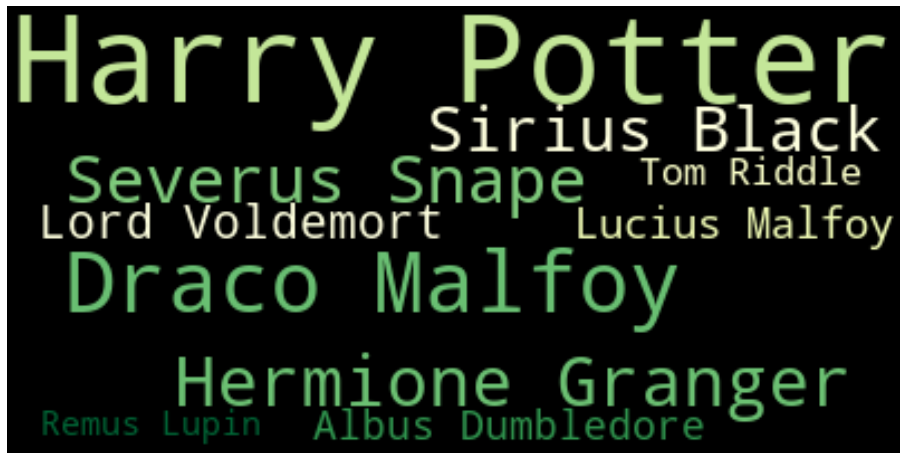

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=180,colormap="YlGn").generate_from_frequencies(top_10_sorted_full_names)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##Топ-10 по частоте пар вида ''профессор'' + имя / фамилия
***
Для решения снова воспользуемся *FreqDist* из библиотеки *NLTK*.
Поиск вхождений снова осуществим через регулярные выражения.  
Единственное отличие - словарь будем наполнять отдельно именами и отдельно фамилиями, чтобы исключить задвоение результатов для однофамильцев и тесок.  


In [ ]:
fd = FreqDist()
for sentence in tqdm(data['sentences']):
    for person in full_names:
        name, surname = person.lower().split()

        regex_surname = f"professor.{surname}"
        regex_name = f"professor.{name}"

        if re.search(regex_surname, sentence):
            fd.update([surname])
        if re.search(regex_name, sentence):
            fd.update([name])

  0%|          | 0/38869176 [00:00<?, ?it/s]

In [ ]:
fd.most_common(10)

[('dumbledore', 120580),
 ('snape', 45352),
 ('mcgonagall', 42949),
 ('lupin', 20176),
 ('weasley', 10395),
 ('flitwick', 9562),
 ('longbottom', 9508),
 ('slughorn', 5860),
 ('sprout', 5811),
 ('potter', 5037)]

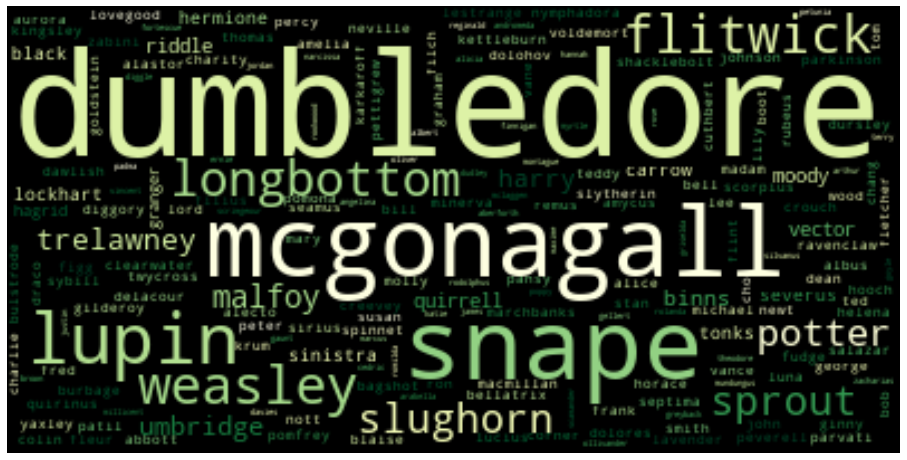

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=180,colormap="YlGn").generate_from_frequencies(fd)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
file = open('top_full_professor', 'w')

for person in tqdm(fd):
    #print(person, fd[person])   
    file.write(f"{person:10s} {fd[person]:10d}\n")
file.close()



  0%|          | 0/236 [00:00<?, ?it/s]

# Word Representation Models
***
Обучить модель представления слов (*word2vec, GloVe, fastText* или любую другую) на материале корпуса HPAC.

Напишем генератор для нашего корпуса.

In [ ]:
def corpus_generator():
    for sentence in data['sentences']:
        yield sentence.split()

Создаем модель, словарь и запускаем процесс обучения.

In [ ]:
model = word2vec.Word2Vec(workers=32, size=100, min_count=5, window=5, sample=1e-3)
model.build_vocab(corpus_generator())
model.train(corpus_generator(), total_examples=model.corpus_count, epochs=10)

(219834907, 238870581)

Некоторые метрики модели.

In [ ]:
print("Total words -->", model.corpus_total_words)
print("Vocabluary size -->",  len(model.wv.vocab.keys()))
print(model.wv.vectors.shape)

Total words --> 238870581
Vocabluary size --> 88165
(88165, 100)


In [ ]:
len(model['university'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


100

### Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели.

In [ ]:
model.wv.most_similar('harry')

[('draco', 0.6881521940231323),
 ('hermione', 0.6839075088500977),
 ('ron', 0.6579885482788086),
 ('daphne', 0.5899916887283325),
 ('ginny', 0.5524231195449829),
 ('chrys', 0.5204444527626038),
 ('luna', 0.5176032781600952),
 ('orev', 0.5016354322433472),
 ('reuben', 0.5015860795974731),
 ('vesper', 0.48842674493789673)]

In [ ]:
model.wv.most_similar('snitch')

[('quaffle', 0.6983073353767395),
 ('quaffles', 0.6378949880599976),
 ('feint', 0.6320146322250366),
 ('seeker', 0.6250633001327515),
 ('hoop', 0.6239743232727051),
 ('goalpost', 0.6059638261795044),
 ('bludgers', 0.5969710350036621),
 ('quaffel', 0.5945944786071777),
 ('pauline', 0.5850601196289062),
 ('broomtail', 0.5819606781005859)]

In [ ]:
model.wv.most_similar('hermione')

[('harry', 0.6839075684547424),
 ('ron', 0.6167484521865845),
 ('ginny', 0.6098706722259521),
 ('lavender', 0.5611701011657715),
 ('caiside', 0.5589306354522705),
 ('pansy', 0.5576964020729065),
 ('daphne', 0.5540773272514343),
 ('draco', 0.5411379337310791),
 ('sabine', 0.5388435125350952),
 ('luna', 0.5337774157524109)]

In [ ]:
model.wv.most_similar('warewolf')

[('turist', 0.8127790689468384),
 ('nomore', 0.8117387294769287),
 ('avake', 0.8100748658180237),
 ('hohoho', 0.8090047836303711),
 ('azrulai', 0.8080188632011414),
 ('blackblade', 0.8061466813087463),
 ('merlina', 0.8048717975616455),
 ('pygmypuff', 0.8036105632781982),
 ('mipsey', 0.8017961978912354),
 ('vampira', 0.8015277981758118)]

Посмотрим топ-3 похожих слов на несколких примерах.

In [ ]:
print(model.wv.most_similar("draco", topn=3))
print(model.wv.most_similar("drink", topn=3))
print(model.wv.most_similar("dementor", topn=3))
print(model.wv.most_similar("magic", topn=3))
print(model.wv.most_similar("broom", topn=3))

[('lucius', 0.6965419054031372), ('harry', 0.6881523132324219), ('pansy', 0.6003418564796448)]
[('butterbeer', 0.7553924918174744), ('firewhisky', 0.7330211400985718), ('firewhiskey', 0.732022225856781)]
[('dementors', 0.7550989985466003), ('lethifold', 0.6135088205337524), ('inferius', 0.6050918102264404)]
[('sorcery', 0.7270429134368896), ('magicks', 0.7017146944999695), ('power', 0.6107531189918518)]
[('firebolt', 0.7959564328193665), ('nimbus', 0.7510700225830078), ('cleansweep', 0.7285629510879517)]


Синонимичность слов.

In [ ]:
print(model.wv.similarity("snape", "severus"))
print(model.wv.similarity("drink", "poison"))
print(model.wv.similarity("broom", "fly"))
print(model.wv.similarity("black", "night"))
print(model.wv.similarity("griffindor", "slytherin"))

0.6128133
0.35513246
0.35394675
0.02453363
0.6086409


In [ ]:
print(model.wv.most_similar(positive=["woman", "man"], topn=3))
print(model.wv.most_similar(positive=["man", "professor"], negative=["professor"], topn=3))
print(model.wv.most_similar(positive=["wizard", "woman", "girl"], negative=["boy", "man"], topn=3))
print(model.wv.most_similar(positive=["snitch", "goal", "broom"], negative=["goal", "broom"], topn=3))

[('crone', 0.7044332027435303), ('biddy', 0.6333614587783813), ('codger', 0.6236191391944885)]
[('woman', 0.7120559215545654), ('coot', 0.6458038687705994), ('crone', 0.63746178150177)]
[('witch', 0.6483925580978394), ('unmarried', 0.5018317103385925), ('magician', 0.4605705440044403)]
[('quaffle', 0.6983073949813843), ('quaffles', 0.6378949880599976), ('feint', 0.6320146322250366)]


Поиск лишних слов.

In [ ]:
print(model.wv.doesnt_match(['harry', 'hermione', 'ron', 'luna']))
print(model.wv.doesnt_match(['harry', 'hermione', 'draco']))
print(model.wv.doesnt_match(['wizard', 'witch', 'raven', 'spell']))
print(model.wv.doesnt_match(['broom', 'wand', 'cage', 'apple']))

luna
hermione
raven
apple


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)

words = [word[0] for word in top_1000_words]
vectors = model[words]
projections = tsne.fit_transform(vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
output_notebook()

tsne_plot = figure(tools="pan,wheel_zoom,reset,save", toolbar_location="above",
           title="Top-1000 most frequent words")
source = ColumnDataSource(data=dict(x1=projections[:,0], x2=projections[:,1], names=words))
tsne_plot.scatter(x="x1", y="x2", size=5, source=source)
labels = LabelSet(x="x1", y="x2", text="names", y_offset=6, text_font_size="8pt",
                  text_color="#555555", source=source, text_align="center")
tsne_plot.add_layout(labels)

show(tsne_plot)

## Классификация текстов
***
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro . Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов.

### FastText в качестве baseline-классификатора.

Подготовим данные для тренировки модели ии её отладки.

In [ ]:
hpac_train = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_training_128.tsv', sep='\t', header=None)
hpac_dev = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_dev_128.tsv', sep='\t', header=None)
hpac_test = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_test_128.tsv', sep='\t', header=None)

In [ ]:
hpac_train

,0,1,2
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi..."
2,4703706.0.8690,STUPEFY,we watched his inglorious withdrawal together ...
3,4593427.0.1815,ACCIO,"my wand , `` incendio . '' this wretched chill..."
4,4278446.0.2692,EXPELLIARMUS,"already compared ours , they 're the same ever..."
...,...,...,...
60975,2790536.0.136,CRUCIO,", evenly matched . good against evil . light a..."
60976,7553216.0.1500,ACCIO,the professor then turned and walked into the ...
60977,2721339.0.1040,DIFFINDO,ran through the crowd below . she felt her eye...
60978,2569402.0.4724,INCENDIO,ministry a decade ago . they recorded his thou...


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words("english")

Для первых испытаний сначала просто уберем из данных стоп-слова.

In [ ]:
def preprocess_text(sentence):
    tokenized_sentence = tokenizer.tokenize(sentence)
    filtered_words = [word for word in tokenized_sentence if not word in stop_words and len(word) > 1]
    clean_sentence = ' '.join(filtered_words)
    return clean_sentence

In [ ]:
hpac_train['cleaned_sentence'] = hpac_train[2].apply(preprocess_text)
hpac_dev['cleaned_sentence'] = hpac_dev[2].apply(preprocess_text)
hpac_test['cleaned_sentence'] = hpac_test[2].apply(preprocess_text)

In [ ]:
hpac_train

,0,1,2,cleaned_sentence
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...,staring next face boggart defense dark arts cl...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi...",whole time first reaction felt quite proud sin...
2,4703706.0.8690,STUPEFY,we watched his inglorious withdrawal together ...,watched inglorious withdrawal together accompa...
3,4593427.0.1815,ACCIO,"my wand , `` incendio . '' this wretched chill...",wand incendio wretched chilly weather getting ...
4,4278446.0.2692,EXPELLIARMUS,"already compared ours , they 're the same ever...",already compared everyday al give let see dada...
...,...,...,...,...
60975,2790536.0.136,CRUCIO,", evenly matched . good against evil . light a...",evenly matched good evil light dark white blac...
60976,7553216.0.1500,ACCIO,the professor then turned and walked into the ...,professor turned walked opening appeared behin...
60977,2721339.0.1040,DIFFINDO,ran through the crowd below . she felt her eye...,ran crowd felt eyes welling tears horrible mus...
60978,2569402.0.4724,INCENDIO,ministry a decade ago . they recorded his thou...,ministry decade ago recorded thoughts spell in...


Собираем наши данные для передачи модели.  
Массив для тренировки.

In [ ]:
X = hpac_train.cleaned_sentence.tolist()
Y = hpac_train[1].tolist()

In [ ]:
print ("total sentences %s" % len(X))
print ("total labels %s" % len(Y))

total sentences 60980
total labels 60980


In [ ]:
with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X)):
        outfile.write('__label__' + Y[i] + ' '+ X[i] + '\n')

Массив для отладки.

In [ ]:
X_D = hpac_dev.cleaned_sentence.tolist()
Y_D = hpac_dev[1].tolist()

In [ ]:
print ("total sentences %s" % len(X_D))
print ("total labels %s" % len(Y_D))

total sentences 7605
total labels 7605


In [ ]:
with open('data.dev.txt', 'w+') as outfile:
    for i in range(len(X)):
        outfile.write('__label__' + Y[i] + ' '+ X[i] + '\n')

Запустим модель и посмотрим метрики.

In [ ]:
classifier_no_stops = fasttext.train_supervised('/content/drive/MyDrive/data.train.txt', lr=0.5, epoch=50, wordNgrams=5, dim=100, loss='ova')
result = classifier_no_stops.test('/content/drive/MyDrive/data.dev.txt')

print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])


P@1: 0.3339907955292571
R@1: 0.3339907955292571
Number of examples: 7605


In [ ]:
print(classifier_no_stops.labels)
print(classifier_no_stops.words)

['__label__AVADA_KEDAVRA', '__label__CRUCIO', '__label__ACCIO', '__label__LUMOS', '__label__STUPEFY', '__label__OBLIVIATE', '__label__EXPELLIARMUS', '__label__LEGILIMENS', '__label__EXPECTO_PATRONUM', '__label__SECTUMSEMPRA', '__label__PROTEGO', '__label__ALOHOMORA', '__label__SCOURGIFY', '__label__INCENDIO', '__label__IMPERIO', '__label__WINGARDIUM_LEVIOSA', '__label__REDUCTO', '__label__PETRIFICUS_TOTALUS', '__label__SILENCIO', '__label__REPARO', '__label__MUFFLIATO', '__label__AGUAMENTI', '__label__FINITE_INCANTATEM', '__label__NOX', '__label__RIDDIKULUS', '__label__INCARCEROUS', '__label__DIFFINDO', '__label__IMPEDIMENTA', '__label__LEVICORPUS', '__label__EVANESCO', '__label__SONORUS', '__label__POINT_ME', '__label__EPISKEY', '__label__ENGORGIO', '__label__CONFRINGO', '__label__COLLOPORTUS', '__label__PORTUS', '__label__TERGEO', '__label__RENNERVATE', '__label__MORSMORDRE', '__label__HOMENUM_REVELIO', '__label__MOBILICORPUS', '__label__EXPULSO', '__label__LOCOMOTOR', '__label__RELA

Проведем анализ полученных предсказаний.

In [ ]:
pred_list = classifier_no_stops.predict(hpac_dev['cleaned_sentence'].tolist())

Удалим маркер из предсказаний для удобства работы.

In [ ]:
def pred_remove_label(prediction):
    return re.sub("__label__", "", prediction)

In [ ]:
no_lable_pred = []
for pred in pred_list[0]:
    no_lable_pred.append(pred_remove_label(pred[0]))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix

Некоторые метрики модели.

In [ ]:
print('Model metrics')
print("Acc. Score --> ", accuracy_score(hpac_dev[1], no_lable_pred))
print("F1. Score --> ", f1_score(hpac_dev[1], no_lable_pred, average='micro'))
print("F1. Score Macro --> ", f1_score(hpac_dev[1], no_lable_pred, average='macro'))
print("Prec. Score --> ", precision_score(hpac_dev[1], no_lable_pred, average='micro'))
print("Recall. Score --> ", recall_score(hpac_dev[1], no_lable_pred, average='micro'))
cm = confusion_matrix(hpac_dev[1], no_lable_pred, normalize='true')

Model metrics
Acc. Score -->  0.3339907955292571
F1. Score -->  0.3339907955292571
F1. Score Macro -->  0.1620507808652445
Prec. Score -->  0.3339907955292571
Recall. Score -->  0.3339907955292571


In [ ]:
pred_class = classifier_no_stops.predict(list(hpac_dev[2]))
true_class = hpac_dev[1]

Посмотрим детально на наши данные.

In [ ]:
scores = f1_score(hpac_dev[1], no_lable_pred, average=None)
for i in range(len(scores)):
    label = classifier_no_stops.labels[i]
    count = hpac_train[hpac_train[1] == label[9:]].shape[0]
    score = scores[i]
    print(f"{label[9:]:20s}\t{count:5d}\t{score:.3f}")

AVADA_KEDAVRA       	 7491	0.326
CRUCIO              	 7378	0.258
ACCIO               	 4168	0.357
LUMOS               	 3894	0.333
STUPEFY             	 3326	0.267
OBLIVIATE           	 2891	0.459
EXPELLIARMUS        	 2728	0.348
LEGILIMENS          	 1725	0.000
EXPECTO_PATRONUM    	 1657	0.125
SECTUMSEMPRA        	 1458	0.061
PROTEGO             	 1396	0.087
ALOHOMORA           	 1263	0.453
SCOURGIFY           	 1244	0.000
INCENDIO            	 1238	0.000
IMPERIO             	 1180	0.105
WINGARDIUM_LEVIOSA  	 1178	0.000
REDUCTO             	 1159	0.139
PETRIFICUS_TOTALUS  	 1134	0.000
SILENCIO            	 1056	0.254
REPARO              	 1036	0.197
MUFFLIATO           	  923	0.000
AGUAMENTI           	  746	0.143
FINITE_INCANTATEM   	  644	0.566
NOX                 	  638	0.177
RIDDIKULUS          	  616	0.062
INCARCEROUS         	  606	0.000
DIFFINDO            	  491	0.059
IMPEDIMENTA         	  491	0.000
LEVICORPUS          	  488	0.000
EVANESCO            	  459	0.222
SONORUS   

Построим визуализацию для confusion matrix.

Text(562.2, 0.5, 'predicted label')

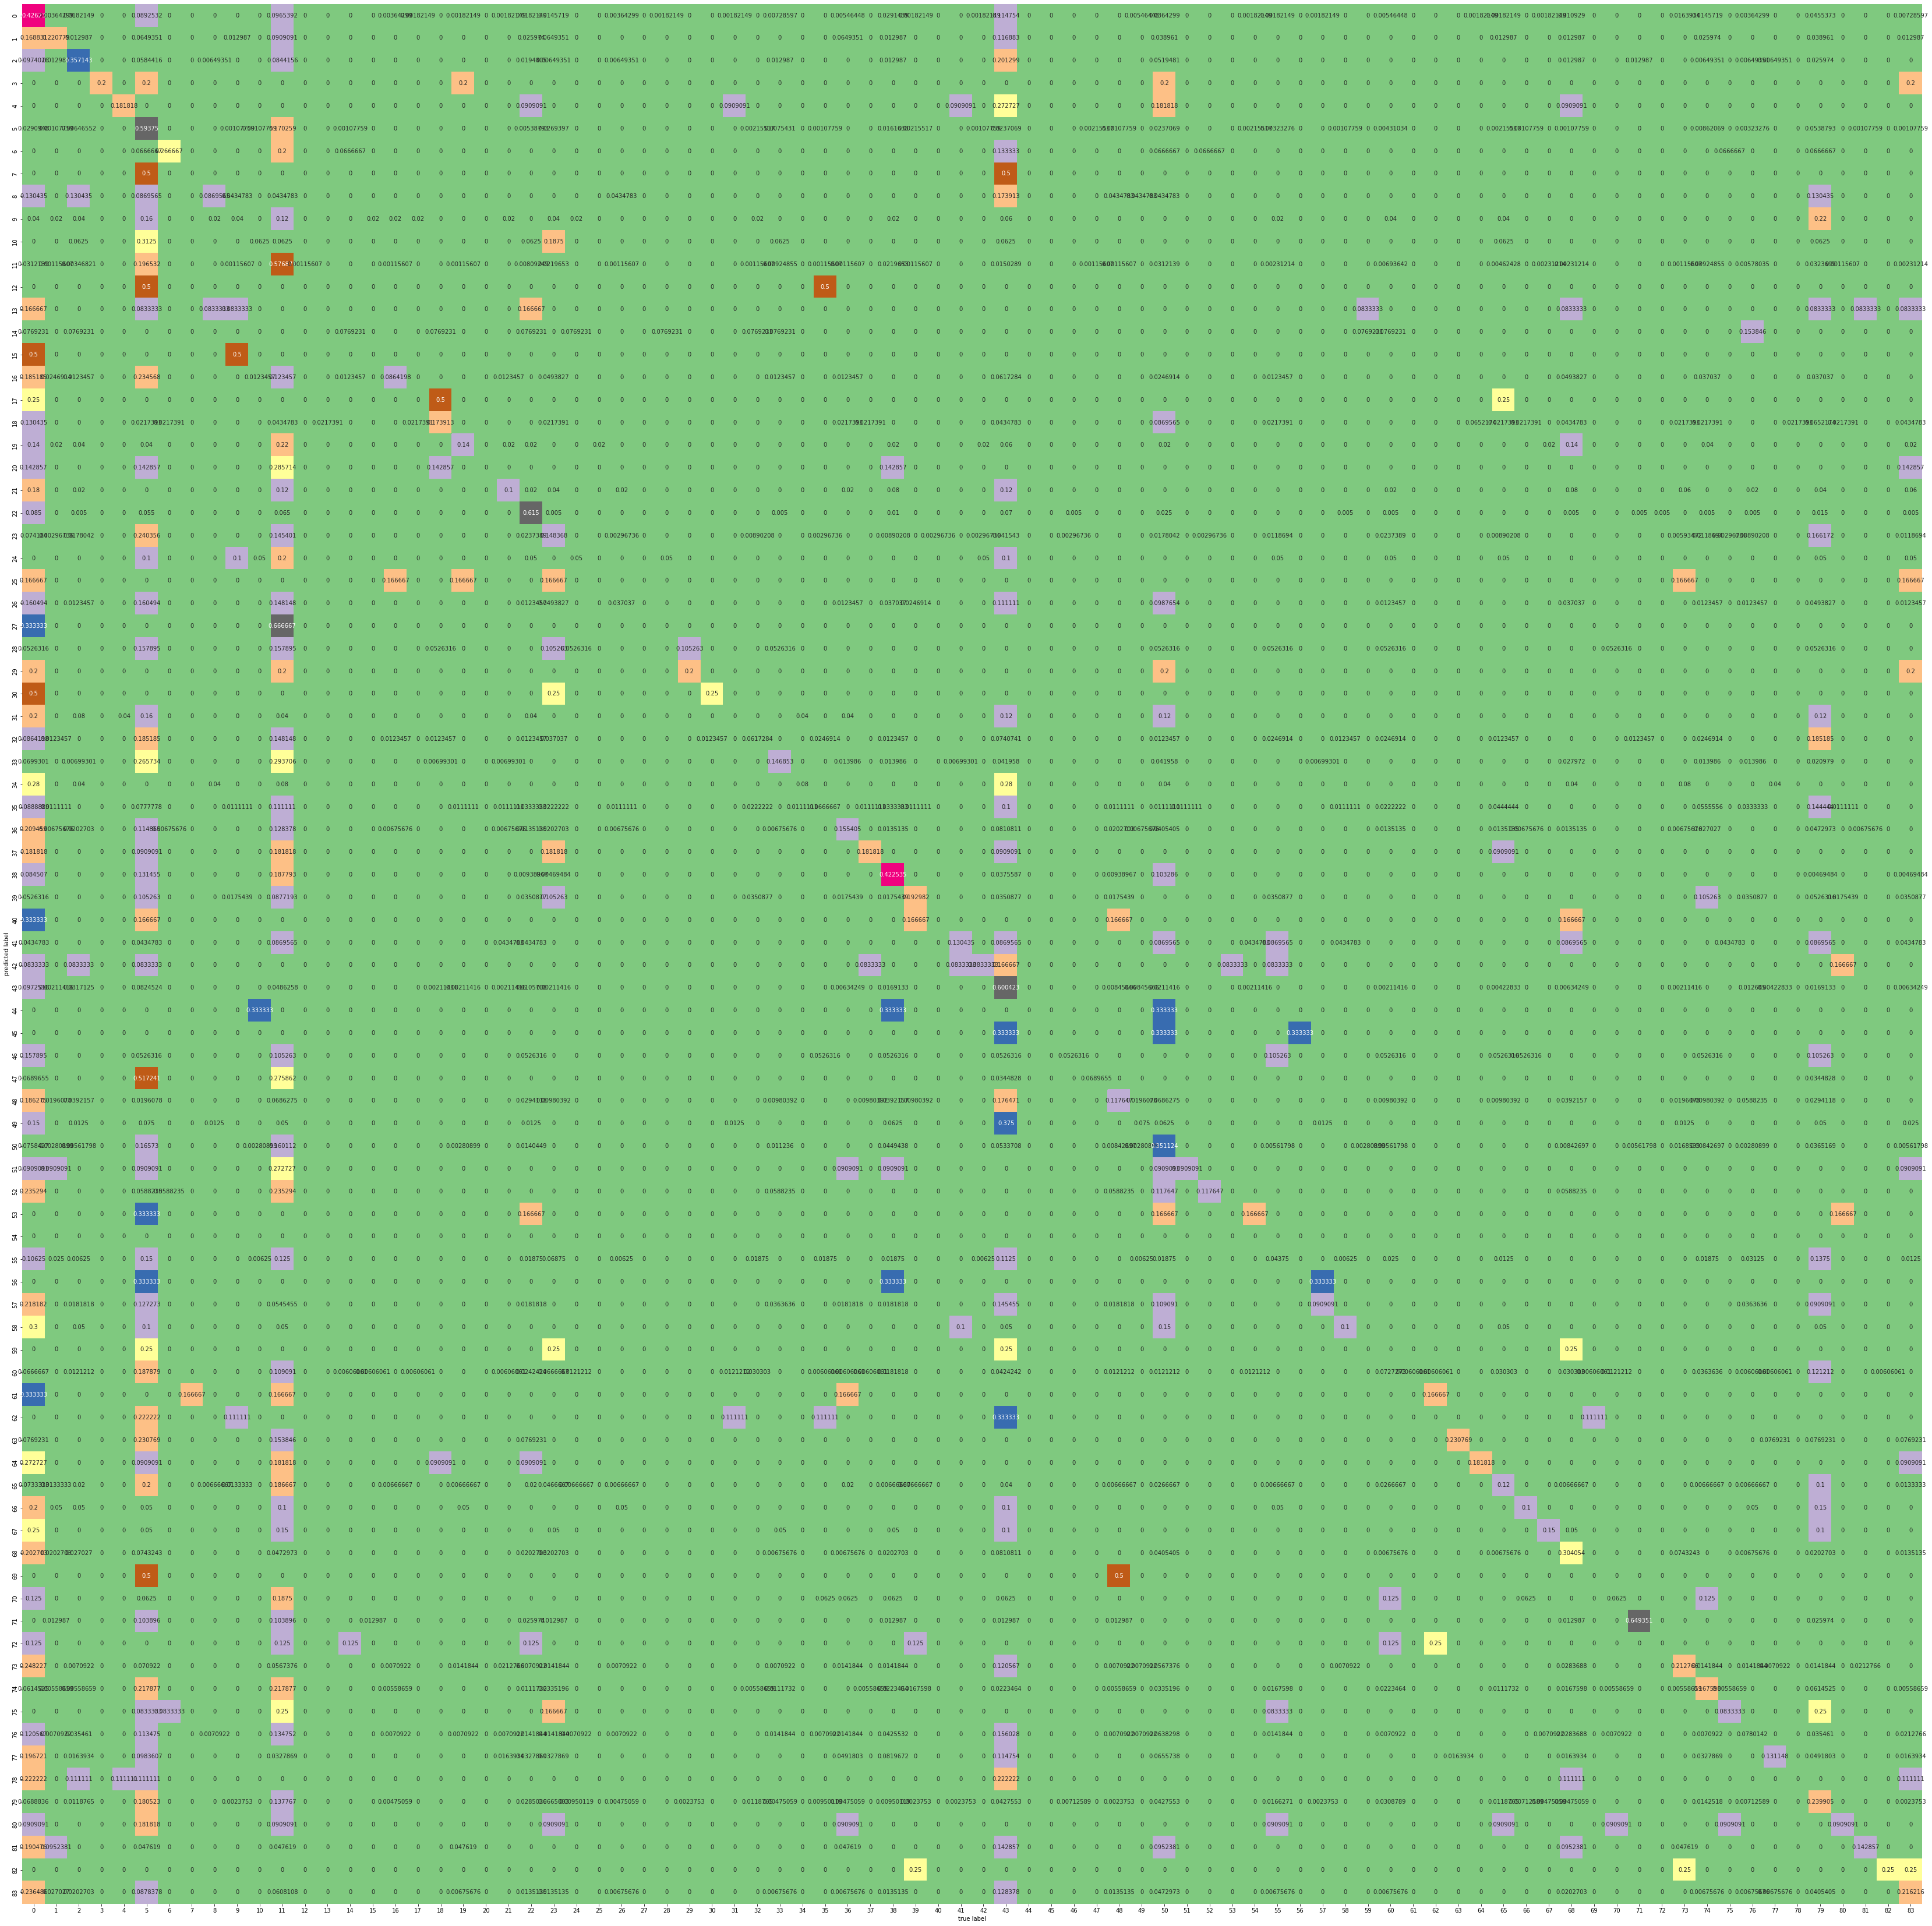

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(60,60))
sns.heatmap(cm, square=True, annot=True, cmap='Accent', cbar=False, fmt='g')
plt.xlabel("true label")
plt.ylabel("predicted label")

### Lemmatization
***
Попробуем привести слова к инфинитиву и повторить процесс.

In [ ]:
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
hpac_train_lemm = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_training_128.tsv', sep='\t', header=None)
hpac_dev_lemm = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_dev_128.tsv', sep='\t', header=None)
hpac_test_lemm = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_test_128.tsv', sep='\t', header=None)

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words("english")

In [ ]:
def preprocess_text_lemm(sentence):
    words = tokenizer.tokenize(sentence)
    filtered_words = [lemmatizer.lemmatize(word, 'v') for word in [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words] if word not in stop_words and len(word) > 1]
    cleaned_sentence = ' '.join(filtered_words)
    return cleaned_sentence

In [ ]:
hpac_train_lemm['cleaned_sentence'] = hpac_train_lemm[2].apply(preprocess_text_lemm)
hpac_dev_lemm['cleaned_sentence'] = hpac_dev_lemm[2].apply(preprocess_text_lemm)
hpac_test_lemm['cleaned_sentence'] = hpac_test_lemm[2].apply(preprocess_text_lemm)

In [ ]:
#hpac_train_lemm['spell_category_str'] = hpac_train_lemm.spell_category.apply(str)
hpac_train_lemm

,0,1,2,cleaned_sentence
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...,staring next face boggart defense dark arts cl...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi...",whole time first reaction felt quite proud sin...
2,4703706.0.8690,STUPEFY,we watched his inglorious withdrawal together ...,watched inglorious withdrawal together accompa...
3,4593427.0.1815,ACCIO,"my wand , `` incendio . '' this wretched chill...",wand incendio wretched chilly weather getting ...
4,4278446.0.2692,EXPELLIARMUS,"already compared ours , they 're the same ever...",already compared everyday al give let see dada...
...,...,...,...,...
60975,2790536.0.136,CRUCIO,", evenly matched . good against evil . light a...",evenly matched good evil light dark white blac...
60976,7553216.0.1500,ACCIO,the professor then turned and walked into the ...,professor turned walked opening appeared behin...
60977,2721339.0.1040,DIFFINDO,ran through the crowd below . she felt her eye...,ran crowd felt eyes welling tears horrible mus...
60978,2569402.0.4724,INCENDIO,ministry a decade ago . they recorded his thou...,ministry decade ago recorded thoughts spell in...


In [ ]:
X_train_lemm = hpac_train_lemm.cleaned_sentence.tolist()
Y_train_lemm = hpac_train_lemm[1].tolist()

In [ ]:
print ("total train examples %s" % len(X_train_lemm))
print ("total test examples %s" % len(Y_train_lemm))

total train examples 60980
total test examples 60980


In [ ]:
with open('data.train_lemm.txt', 'w+') as outfile:
    for i in range(len(X_train_lemm)):
        outfile.write('__label__' + Y_train_lemm[i] + ' '+ X_train_lemm[i] + '\n')

In [ ]:
X_dev_lemm = hpac_dev_lemm.cleaned_sentence.tolist()
Y_dev_lemm = hpac_dev_lemm[1].tolist()

In [ ]:
X_test_lemm = hpac_test_lemm.cleaned_sentence.tolist()
Y_test_lemm = hpac_test_lemm[1].tolist()

In [ ]:
with open('data.dev.lemm.txt', 'w+') as outfile:
    for i in range(len(X_dev_lemm)):
        outfile.write('__label__' + Y_dev_lemm[i] + ' '+ X_dev_lemm[i] + '\n')

In [ ]:
with open('data.test.lemm.txt', 'w+') as outfile:
    for i in range(len(X_test_lemm)):
        outfile.write('__label__' + Y_test_lemm[i] + ' '+ X_test_lemm[i] + '\n')

In [ ]:
classifier_lemm = fasttext.train_supervised(input='/content/drive/MyDrive/data.train_lemm.txt', lr=0.5, epoch=50, wordNgrams=5, dim=100, loss='ova')

In [ ]:
result = classifier_lemm.test('/content/drive/MyDrive/data.dev.lemm.txt')

print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])

P@1: 0.33872452333990793
R@1: 0.33872452333990793
Number of examples: 7605


In [ ]:
result = classifier_lemm.test('/content/drive/MyDrive/data.test.lemm.txt')

print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])

P@1: 0.30147154577418933
R@1: 0.30147154577418933
Number of examples: 7679


### LSTM Model

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Прочитаем наши данные и переведем заклинания в числовые классификаторы.

In [ ]:
hpac_train = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_training_128.tsv', sep='\t', header=None)
hpac_dev = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_dev_128.tsv', sep='\t', header=None)
hpac_test = pd.read_csv('/content/drive/MyDrive/harry_potter_data/hpac_corpus/hpac_test_128.tsv', sep='\t', header=None)

spells2target = {spell:num for num, spell in enumerate(hpac_train[1].unique())}

Осуществим предобработку текста. Выбросим стоп-слова, проведем лемматизацию.

In [ ]:
st_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
hpac_train['cleaned_sentence'] = hpac_train[2].apply(preprocess_text_lemm)
hpac_train['target'] = hpac_train[1].map(spells2target)

In [ ]:
hpac_dev['cleaned_sentence'] = hpac_dev[2].apply(preprocess_text_lemm)
hpac_dev['target'] = hpac_dev[1].map(spells2target)

In [ ]:
hpac_test['cleaned_sentence'] = hpac_test[2].apply(preprocess_text_lemm)
hpac_test['target'] = hpac_test[1].map(spells2target)

In [ ]:
train = hpac_train[['cleaned_sentence', 'target']]
dev = hpac_dev[['cleaned_sentence', 'target']]
test = hpac_test[['cleaned_sentence', 'target']]

Для LSTM модели я решил объединить наши данные и потом заново разбить их на обучающее, отладочное и тестовое множество, так как в предложенных выборках очень большой дисбаланс.

In [ ]:
my_data = pd.concat([train, dev, test], axis=0)
my_data.to_csv('lstm', index=False)

Посмотрим на характеристики полученного датасета.

In [ ]:
my_data['len'] = my_data['cleaned_sentence'].str.split().apply(len)
my_data['len'].describe()

count    76264.000000
mean        51.861114
std          8.554085
min          0.000000
25%         48.000000
50%         53.000000
75%         57.000000
max        106.000000
Name: len, dtype: float64

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 106 #250
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(my_data['cleaned_sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39911 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(my_data['cleaned_sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (76264, 106)


In [ ]:
Y = pd.get_dummies(my_data['target']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (76264, 85)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(68637, 106) (68637, 85)
(7627, 106) (7627, 85)


In [ ]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train,Y_train, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_dev.shape,Y_dev.shape)

(61773, 106) (61773, 85)
(6864, 106) (6864, 85)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(85, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 106, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 85)                8585      
                                                                 
Total params: 5,088,985
Trainable params: 5,088,985
Non-trainable params: 0
_________________________________________________________________
None


Обучим нашу модель.

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_dev, Y_dev), batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
966/966 [==============================] - 788s 809ms/step - loss: 3.2552 - accuracy: 0.1769 - val_loss: 2.9872 - val_accuracy: 0.2582
Epoch 2/5
966/966 [==============================] - 768s 795ms/step - loss: 2.7907 - accuracy: 0.2961 - val_loss: 2.7542 - val_accuracy: 0.3154
Epoch 3/5
966/966 [==============================] - 744s 770ms/step - loss: 2.5171 - accuracy: 0.3647 - val_loss: 2.6917 - val_accuracy: 0.3344
Epoch 4/5
966/966 [==============================] - 755s 782ms/step - loss: 2.3259 - accuracy: 0.4106 - val_loss: 2.6749 - val_accuracy: 0.3429
Epoch 5/5
966/966 [==============================] - 771s 798ms/step - loss: 2.1511 - accuracy: 0.4504 - val_loss: 2.6998 - val_accuracy: 0.3466


Некоторые метрики и визуализация процесса обучения.

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

239/239 [==============================] - 10s 43ms/step - loss: 2.7258 - accuracy: 0.3347
Test set
  Loss: 2.726
  Accuracy: 0.335


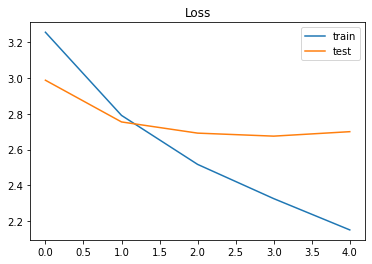

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

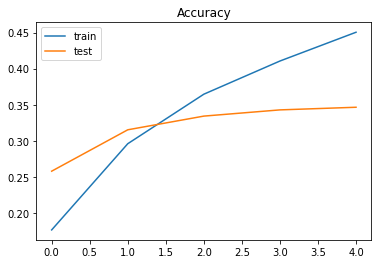

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
model.save("hpac_lemm_lstm")

INFO:tensorflow:Assets written to: hpac_lemm_lstm/assets


Постром визуализацию 1000 предложений с помощью tSNE.

In [ ]:
def create_truncated_model(trained_model):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH))
    #model.add(Bidirectional(LSTM(64)))
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict(X_test)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=85)
pca_result = pca.fit_transform(X_test)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))



tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:1000])

Variance PCA: 0.9999999995072295
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.124s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4022.219522
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.911591
[t-SNE] KL divergence after 1000 iterations: 1.623529


<Figure size 720x720 with 0 Axes>

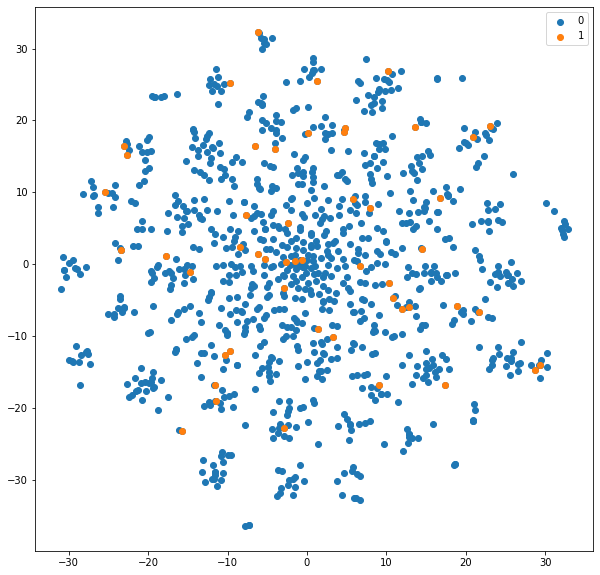

In [ ]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(Y_test[:1000], num_classes = 2)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()


## Synonymization and Augmentation
***
Попробуем расширить обучающее множество за счет аугментации данных.

Напишем функцию для поиска сининимов и замены некоторых слов в наших предложениях.

In [ ]:
def augment_synonyms(sentence, th = 0.6):
    words = sentence.split()
    is_change = np.random.rand(len(words)) > th
    new_words = []
    
    for i, word in enumerate(words):
        if is_change[i]:
            sets = wn.synsets(word)
            if not len(sets):
                continue
            synset = np.random.choice(sets)
            new = np.random.choice(synset.lemmas()).name().lower().split('_')
            if isinstance(new, list):
                new_words += new
            else:
                new_words.append(new)
        else:
            new_words.append(word)
    return ' '.join(new_words)

In [ ]:
hpac_train_lemm['syn_sent'] = hpac_train_lemm['cleaned_sentence'].apply(augment_synonyms)

In [ ]:
hpac_train_lemm

,0,1,2,cleaned_sentence,syn_sent
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...,star next face boggart defense dark art class ...,star next face boggart defense dark art class ...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi...",whole time first reaction felt quite proud sin...,completely time number one reaction felt quite...
2,4703706.0.8690,STUPEFY,we watched his inglorious withdrawal together ...,watch inglorious withdrawal together accompany...,watch inglorious withdrawal method together ac...
3,4593427.0.1815,ACCIO,"my wand , `` incendio . '' this wretched chill...",wand incendio wretched chilly weather get nerv...,wand incendio poor chilly weather get nerve fi...
4,4278446.0.2692,EXPELLIARMUS,"already compared ours , they 're the same ever...",already compare everyday al give let see dada ...,already compare everyday al give let go out pa...
...,...,...,...,...,...
60975,2790536.0.136,CRUCIO,", evenly matched . good against evil . light a...",evenly match good evil light dark white black ...,evenly match good malign light dark egg white ...
60976,7553216.0.1500,ACCIO,the professor then turned and walked into the ...,professor turn walk open appear behind gargoyl...,professor turn walk open come along behindhand...
60977,2721339.0.1040,DIFFINDO,ran through the crowd below . she felt her eye...,run crowd felt eye well tear horrible must rem...,run crowd felt eye well tear horrible must rem...
60978,2569402.0.4724,INCENDIO,ministry a decade ago . they recorded his thou...,ministry decade ago record think spell instiga...,ministry decade ago record think spell instiga...


In [ ]:
X_train_syn = hpac_train_lemm.syn_sent.tolist()
Y_train_syn = hpac_train_lemm[1].tolist()

In [ ]:
with open('data.train_syn.txt', 'w+') as outfile:
    for i in range(len(X_train_syn)):
        outfile.write('__label__' + Y_train_syn[i] + ' '+ X_train_syn[i] + '\n')

In [ ]:
classifier_synonyms = fasttext.train_supervised(input='/content/drive/MyDrive/data.train_syn.txt', lr=0.5, epoch=50, wordNgrams=5, dim=100, loss='ova')
result = classifier_synonyms.test('/content/drive/MyDrive/data.dev.lemm.txt')

print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])

P@1: 0.32807363576594345
R@1: 0.32807363576594345
Number of examples: 7605


###Аугментация данных

Переведем наши заклинания в числовые классы.

In [ ]:
spells_to_target = {spell:num for num, spell in enumerate(hpac_train_lemm[1].unique())}
hpac_train_lemm['target'] = hpac_train_lemm[1].map(spells_to_target)
hpac_dev_lemm['target'] = hpac_dev_lemm[1].map(spells_to_target)

In [ ]:
hpac_dev_lemm

,0,1,2,cleaned_sentence,target
0,10873161.0.5925,PROTEGO,could do . kingsley vanished the chair that ro...,could kingsley vanish chair ronald sit erect p...,4
1,7657727.0.5782,STUPEFY,"student in the castle , and she 'll be damned ...",student castle damn run away leaf love without...,1
2,2981611.0.971,ACCIO,"regulus black '' `` well , at least he has a s...",regulus black well least sense humor sirius re...,2
3,8409475.0.5941,ACCIO,outside on the quidditch pitch or near the lak...,outside quidditch pitch near lake belief remai...,2
4,2082596.0.429,CRUCIO,for them . slowly his happiness drains away du...,slowly happiness drain away lesson father lect...,6
...,...,...,...,...,...
7600,4833934.0.1713,REPARO,"she sank back onto the ground , feeling weak a...",sink back onto grind feel weak undo tear strea...,40
7601,12665066.0.301,NOX,greyback . greyback started to advance towards...,greyback greyback start advance towards sirius...,43
7602,6377162.0.13175,SONORUS,rescued all of the people who were underwater ...,rescue people underwater prevent contestant pe...,20
7603,12375286.0.18091,HOMENUM_REVELIO,to get up sirius cast a quick sleeping charm a...,get sirius cast quick sleep charm place stasis...,58


Разделим данные на обучающие и проверочные.

In [ ]:
from sklearn import model_selection, preprocessing, metrics, linear_model, svm

train_x, train_y = hpac_train_lemm['cleaned_sentence'], hpac_train_lemm['target']
valid_x, valid_y = hpac_dev_lemm['cleaned_sentence'], hpac_dev_lemm['target']

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

Рассчитаем TF-IDF признаки.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(hpac_train_lemm['cleaned_sentence'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

Точность в качестве метрики работает хорошо только на сбалансированных наборах данных, поэтому для оценки результатов работы алгоритма будем использовать F1-метрику.

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    classifier.fit(feature_vector_train, label)

    predictions = classifier.predict(feature_vector_valid)    

    return metrics.f1_score(valid_y,predictions, average='micro')

Обучим лог-регрессию.

In [ ]:
accuracyORIGINAL = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),xtrain_tfidf, train_y, xvalid_tfidf)
print ("Logistic regression Baseline, WordLevel TFIDF: ", accuracyORIGINAL)

Logistic regression Baseline, WordLevel TFIDF:  0.315318869165023


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline

Under-sampling уравновешивает данные за счет уменьшения размера превалирующего класса. Этот метод разумно использовать, когда количество данных достаточно велико, иначе есть риск остаться и вовсе без обучающих примеров.


In [ ]:
rus = RandomUnderSampler(random_state=0, replacement=True)
rus_xtrain_tfidf, rus_train_y = rus.fit_resample(xtrain_tfidf, train_y)
accuracyrus = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),rus_xtrain_tfidf, rus_train_y, xvalid_tfidf)
print ("Logistic regressio RUS, WordLevel TFIDF: ", accuracyrus)

Logistic regressio RUS, WordLevel TFIDF:  0.04049967126890204


###Over-sampling
Итак, когда данных недостаточно или количество экземпляров в миноритарном классе очень мало применяется Over-sampling.

При применении этой техники балансировка данных происходит за счет увеличения количества экземпляров в миноритарном классе. Новые элементы генерируются за счет: повторения, бутстрэппинга, SMOTE (Synthetic Minority Over-Sampling Technique) или ADASYN (Adaptive synthetic sampling).

**Random Over-sampling**: случайным образом дублируются некоторые элементы из миноритарного класса.

In [ ]:
#Random Over Sampling
ros = RandomOverSampler(random_state=777)
ros_xtrain_tfidf, ros_train_y = ros.fit_resample(xtrain_tfidf, train_y)
accuracyROS = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),ros_xtrain_tfidf, ros_train_y, xvalid_tfidf)
print ("Logistic regression ROS, WordLevel TFIDF: ", accuracyROS)

Logistic regression ROS, WordLevel TFIDF:  0.25877712031558187


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SMOTE Over-sampling

Алгоритм SMOTE основан на идее генерации некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе, но при этом не дублировали их.

Для создания новой записи находят разность  d=Xb−Xa,  где  Xb,Xa−  векторы признаков «соседних» примеров  a  и  b  из миноритарного класса.

Их находят, используя алгоритм ближайшего соседа (KNN). В данном случае необходимо и достаточно для примера  b  получить набор из  k  соседей, из которого в дальнейшем будет выбрана запись  b . Остальные шаги алгоритма KNN не требуются.

Далее из  d  путем умножения каждого его элемента на случайное число в интервале (0, 1) получают  d^ . Вектор признаков нового примера вычисляется путем сложения  Xa  и  d^ .

Алгоритм SMOTE позволяет задавать количество записей, которое необходимо искусственно сгенерировать. Степень сходства примеров  a  и  b  можно регулировать путем изменения значения  k  (числа ближайших соседей).

In [ ]:
tatget_dict = hpac_train_lemm['target'].value_counts().to_dict()
def get_key(val):
    for key, value in tatget_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

res = {}
for item in tatget_dict.values():
    if item < 500:
        res[get_key(item)] = item


Посмотрим на распределение наших классов.

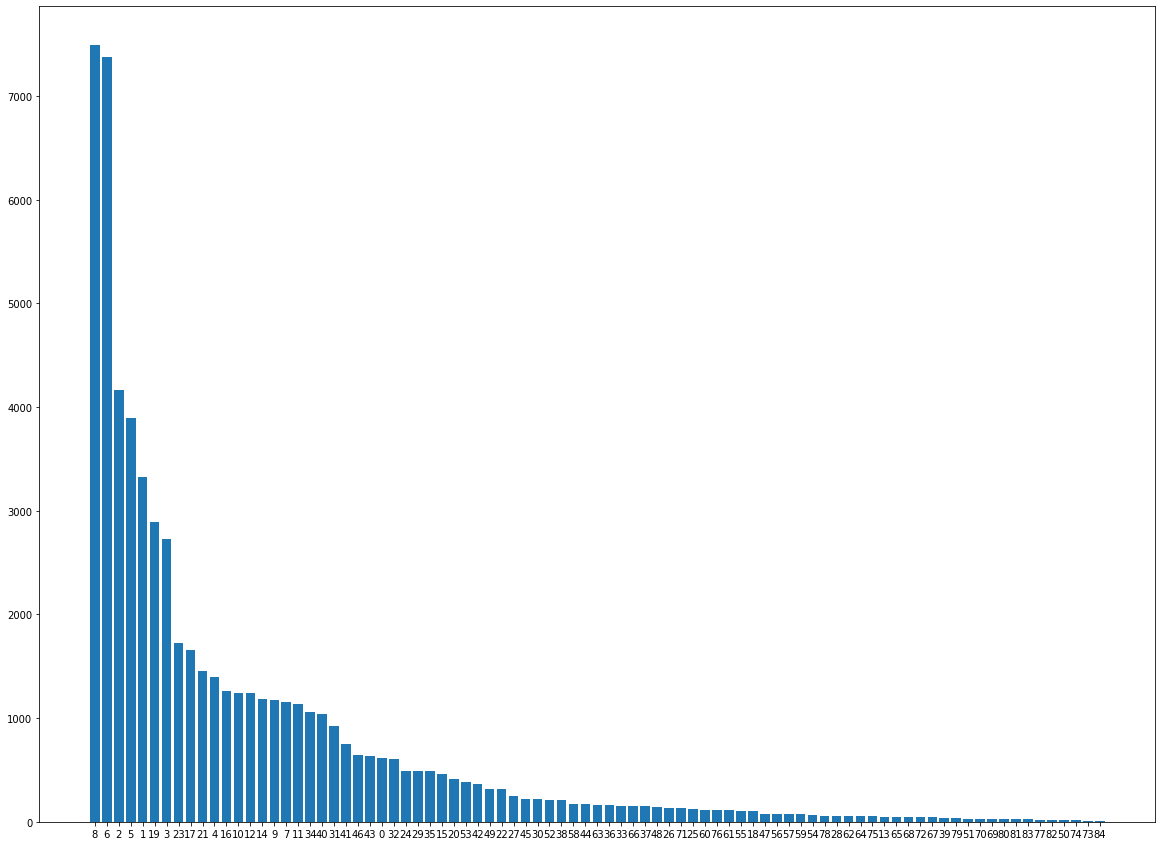

In [ ]:
data = tatget_dict
names = list(data.keys())
values = list(data.values())
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(range(len(data)), values, tick_label=names)
plt.show()

In [ ]:
sm = SMOTE(random_state=777, sampling_strategy=tatget_dict)
sm_xtrain_tfidf, sm_train_y = sm.fit_resample(xtrain_tfidf, train_y)
accuracySMOTE = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),sm_xtrain_tfidf, sm_train_y, xvalid_tfidf)
print ("Logistic regression SMOTE, WordLevel TFIDF: ", accuracySMOTE)

Logistic regression SMOTE, WordLevel TFIDF:  0.315318869165023


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Следующий алгоритм ASMO: Adaptive synthetic minority oversampling.

Сгенерировать искусственные записи в пределах отдельных кластеров на основе всех классов. Для каждого примера миноритарного класса находят m ближайших соседей, и на основе них (также как в SMOTE) создаются новые записи.

Если для каждого  i -ого примера миноритарного класса из  k  ближайших соседей  g  ( g≤k ) принадлежит к мажоритарному, то набор данных считается «рассеянным». В этом случае используют алгоритм ASMO, иначе применяют SMOTE (как правило,  g  задают равным 20).
Используя только примеры миноритарного класса, выделить несколько кластеров (например, алгоритмом  k -means).
Сгенерировать искусственные записи в пределах отдельных кластеров на основе всех классов. Для каждого примера миноритарного класса находят m ближайших соседей, и на основе них (также как в SMOTE) создаются новые записи.
Такая модификация алгоритма SMOTE делает его более адаптивным к различным наборам данных с несбалансированными классами.

In [ ]:
ad = ADASYN(random_state=777, sampling_strategy=res)
ad_xtrain_tfidf, ad_train_y = ad.fit_resample(xtrain_tfidf, train_y)
accuracyADASYN = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),ad_xtrain_tfidf, ad_train_y, xvalid_tfidf)
print ("Logistic regression ADASYN, WordLevel TFIDF: ", accuracyADASYN)

Logistic regression ADASYN, WordLevel TFIDF:  0.315318869165023


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


###Комбинация Under- и Over-sampling
В imblearn реализованы две возможные комбинации:

*  SMOTE + ENN
*  SMOTE + Tomek Link Removal (Пара двух ближайших соседей, которые принадлежат разным классам называется Tomek link. Under-sampling заключается в удалении всех таких элементов из мажоритарного класса)

In [ ]:
se = SMOTEENN(random_state=42, sampling_strategy=res)
se_xtrain_tfidf, se_train_y = se.fit_resample(xtrain_tfidf, train_y)
accuracy = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),se_xtrain_tfidf, se_train_y, xvalid_tfidf)
print ("Logistic regression SMOTEENN: ", accuracy)

Logistic regression SMOTEENN:  0.16476002629848785


In [ ]:
se = SMOTETomek(random_state=42, sampling_strategy=tatget_dict)
se_xtrain_tfidf, se_train_y = se.fit_resample(xtrain_tfidf, train_y)
accuracy = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),se_xtrain_tfidf, se_train_y, xvalid_tfidf)
print ("Logistic regression SMOTETomek: ", accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic regression SMOTETomek:  0.31650230111768574


##Итоги
***
###Эксплоративный анализ
В качестве взодных данныя я выбрал сырые тексты.  
Результаты предобработки я выбирал из трех подходов:
1.  Приведение к нижнему регистру, удаление символов и стоп-слов, токенизация предложений.  
2.  Приведение к нижнему регистру, удаление символов, стоп-слов, токенизация предложений, а также приведение глаголов к ифинитиву.  
3.  Приведение к нижнему регистру, удаление символов, стоп-слов, токенизация предложений, а также приведение всех слов к ифинитиву.  

В итоге 3 метод показал наилучшие результаты для дальней работы.  

####Подсчет топ-1000 слов  
Вполне ожидемый результат - в топе слов присутствуют основные герои: Гарри, Гермиона, Драко, Рон и т.д. Много глаголов характерных для большого количества дилогов. Почти все глаголы - популярные в повседневной речи, простые, что навеное характерно для фанфиков.  
####Подсчет имен  
Искать экслюзивные для фанфиков имена персонажей я не стал, так как они врядли бы попали в топ из-за своей уникальности. Можно было использовать NER tagger Стэнфорда, но мне показалось для такой задачи модно просто использовать уже известные списки имен персонажей и ставнить слова в нашем датасете с ними.  
Результат - все самые популярные персонажи в топ-10.
####Подсчет пар (Имя, Фамилия)
Реализовал так же как и поиск имен, единственное, оказалось что данные везде разнятся и список полных имен оказался больше чам список просто имен. Так же в сиске было много фамилий без имени и встречались дубликаты.
Результат так же вполне предсказуем.
####Подсчет пар (Профессор, Имя/Фамилия)
Реализовал через регулярные выражения.
Лидер, как и ожидалось, Профессор Дамблдор. Второе и третье место у наиболее популярных преподавателей: Профессор Снейп и МакГонагл.
Есть и сюрпризы, Визли и Поттер. Скорее всего Гарри и Рон решили продолжить научные изыскания и стали профессорами.
***
###Модели представления слов
Реализовал через Word2Vec, так как изначально хотел попробовать все модели.
Результаты анализа синонимов и схожести вполне реалистичны. Любопытно, что если увеличить размер вектора, модель начинает находить очень далекие аналогии, правда при этом снижается близость схожих слов, но можно находить интресные повороты сюжета. Например для Снэйпа модель выдала одним из синонимов Авалон, видимо в каком-то рассказе герои отправились к королю Артуру. 

Визуализации демонстрирует появиление кластеров: чисел, цветов, еды, напитков,факультетов, персонажей, чувств, направлений и т.д.
***
###Классификация текста
Fasttext   
Данные очень сильно не сбалансированы, соответственно скор получился невысокий.  
Из доп методов - лемматизация дала небольшую прибавку к результату.  
LSTM  
Показала себя лучше, также после применения лемматизации результат улучшился.
Я думаю немного поработав с датасетом можно заметно улучшить качество.
Можно отметить, что заклинания, предназначенные для гораздо более конкретных целей определяются с большей верояностью.  
Синонимы и аугментация  
Из примененных подходов наболее хорошо себя показал SMOTE + Tomek Link Removal.
Я пробовал различные варианты *sampling_strategy*, но перекос по количеству случаев в классах очень велик чтобы это оказало значимый результат.
Так же я хотел доработать датасет смешав его с полученными синонимами фраз и выкинув выбросы, но к сожалению не хватило времени.